<a href="https://colab.research.google.com/github/Nebius-Academy/LLM-Engineering-Essentials/blob/main/topic2/r.1_intro_to_llm_reasoning_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Engineering Essentials, R1. Intro to LLM Reasoning

# Practice solutions

## Task 1. Mapping LLM "thoughts"

In this task, we'll look closer at "thinking patters" of LLMs:

- We'll look closer at an LLM's "tree of thoughts",
- We'll investigate how long the typical thoughts are,
- We'll explore the "underthinking" phenomenon.

To have something to experiment with, we'll run evaluation of **QwQ-32B-Preview** on a subset of [MATH benchmark](https://huggingface.co/datasets/nlile/hendrycks-MATH-benchmark). This benchmark is relatively challenging, but to a reasonable extent. It's not [FrontierMath](https://epoch.ai/frontiermath) :)

We'll take the first 50 problems that satisfy two following conditions:

- Their answer is either straightforwardly converted to `float`, or it's a simple Latex-formatted fraction, like `\frac{2}{3}`.
- Their "level" is either 4 ot 5 (more challenge!).

**Note** You can use **deepseek-ai/DeepSeek-R1**, if you want, but it will generate solutions *very* slowly (not mentioning the cost).

Also, if you don't want to run the evaluation of **QWQ** on your own, you may download the `qwq_results.pkl` file from Google drive:

In [ ]:
!gdown 1_hEX_h7fj6FXH3lG5AMthJjiK1JwAU9J

### Evaluating QWQ on MATH Dataset

If you're in, let's create the evaluator. And we'll start by data preprocessing.

In [ ]:
!pip install -q datasets

In [ ]:
from datasets import load_dataset
ds = load_dataset('nlile/hendrycks-MATH-benchmark', split='test')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.57k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/5.12M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/210k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
import re

def conver_string_to_number(s):
    """
    Checks if a string is a number or a fraction and computes the fraction if applicable.

    Args:
        s: The input string.

    Returns:
        A float representing the number or fraction, or None if the string is invalid.
    """
    if "_" in s:
        return None

    try:
        return float(s)  # Try converting to a float directly
    except ValueError:
        match = re.match(r"\\frac\{(\d+)\}\{(\d+)\}", s)
        if match:
            numerator = int(match.group(1))
            denominator = int(match.group(2))
            if denominator != 0:
                return numerator / denominator
            else:
                return None  # Handle division by zero
        else:
            return None  # String is not a number or a valid fraction

# Example usage
strings = ["123", "\\frac{1}{2}", "\\frac{3}{0}", "abc", "\\frac{4}{5}"]
for s in strings:
    result = conver_string_to_number(s)
    if result is not None:
        print(f"'{s}' is a valid number or fraction. Result: {result}")
    else:
        print(f"'{s}' is not a valid number or fraction.")


'123' is a valid number or fraction. Result: 123.0
'\frac{1}{2}' is a valid number or fraction. Result: 0.5
'\frac{3}{0}' is not a valid number or fraction.
'abc' is not a valid number or fraction.
'\frac{4}{5}' is a valid number or fraction. Result: 0.8


In [ ]:
import pandas as pd


df = pd.DataFrame(ds)

df['num_answer'] = df['answer'].apply(conver_string_to_number)
df['valid_answer'] = df['num_answer'].notna()

# Select the first 50 rows where the 'answer' column passes the check
selected_rows = df[(df['valid_answer']) & (df['level'] >= 4)].head(50)
selected_rows

,problem,solution,answer,subject,level,unique_id,num_answer,valid_answer
9,The expression $2\cdot 3 \cdot 4\cdot 5+1$ is ...,"By the associative property of multiplication,...",4,Prealgebra,5,test/prealgebra/1139.json,4.000000,True
11,Let $p(x)$ be a polynomial of degree 5 such th...,Let $q(x) = (x^2 - 1) p(x) - x.$ Then $q(x)$ ...,\frac{3}{56},Intermediate Algebra,5,test/intermediate_algebra/1197.json,0.053571,True
12,"The proper divisors of 12 are 1, 2, 3, 4 and 6...",Prime factorize $284=2^2\cdot71$. The sum of t...,284,Number Theory,5,test/number_theory/737.json,284.000000,True
22,Denali and Nate work for a dog walking busines...,"Rewriting the sentence ""the ratio of Denali's ...",5,Algebra,5,test/algebra/1837.json,5.000000,True
24,"A worker receives an annual wage of $\$20{,}00...","If the interest rate is $r$, it follows that $...",10,Algebra,5,test/algebra/2427.json,10.000000,True
26,In how many ways can $7$ people sit around a r...,"After Pierre sits, we can place Rosa either tw...",144,Counting & Probability,5,test/counting_and_probability/525.json,144.000000,True
32,In how many ways can 8 people sit around a rou...,First choose three consecutive seats for Pierr...,720,Counting & Probability,4,test/counting_and_probability/134.json,720.000000,True
33,Consider the geometric sequence $\frac{125}{9}...,The common ratio between consecutive terms is ...,\frac{243}{625},Algebra,4,test/algebra/1072.json,0.388800,True
34,Find the constant term in the expansion of $$\...,"To get a constant term, the exponents of $x$ m...",-125,Counting & Probability,4,test/counting_and_probability/119.json,-125.000000,True
41,"The coordinates of a parallelogram are (5, 3),...","Name the points $A(5,3)$, $B(6,8)$, $C(7,4)$, ...",17,Geometry,4,test/geometry/627.json,17.000000,True


The evaluator itself:

In [ ]:
import pandas as pd
from typing import List, Dict, Tuple
import json
from pathlib import Path
import numpy as np
from tqdm import tqdm
import re

from openai import OpenAI

from datasets import load_dataset

def find_boxed_content(text):
    matches = re.findall(r"boxed\{(.*?)\}", text)
    try:
        return conver_string_to_number(matches[-1])
    except:
        try:
            return conver_string_to_number(text.split("\n")[-1].split(" ")[-1].strip(".;$"))
        except:
            print(f"""Wrong format in:
                {text.split()[-1]}""")
            return None

class MATHEvaluator:
    def __init__(self, system_prompt: str = "You are a helpful assistant.",
                 prompt: str = None):
        """
        Initialize the MATH evaluator.

        Args:
            system_prompt: Optional system prompt for the model
            prompt: Custom prompt for the model
        """

        self.system_prompt = system_prompt

        self.prompt = """{question}"""

        self.questions, self.answers = selected_rows["problem"].to_list(), selected_rows["num_answer"].to_list()

    def extract_answer(self, solution: str) -> str:
        """
        Extract the letter answer from model's response.

        Args:
            response: Raw model response

        Returns:
            Extracted answer (an float)
        """
        # Look for a single letter answer in the response
        try:
            # answer = float(solution.split("\n").split(" ")[1].strip(".;)"))
            answer = find_boxed_content(solution)
        except:
            answer = None
        # print(solution.split("\n")[-1])
        # print(answer)
        return answer

    def evaluate_single_question(self, question: str,
                                 correct_answer: float,
                                 client, model, max_tokens,
                                 temperature=None) -> Tuple[bool, str]:
        """
        Evaluate a single question.

        Args:
            question: Formatted question string
            correct_answer: Correct answer letter

        Returns:
            Tuple of (is_correct, extracted_answer, model_response)
        """
        try:
            model_response = answer_with_llm(
                prompt=self.prompt.format(
                    question=question
                ),
                client=client, model=model,
                system_prompt=self.system_prompt,
                max_tokens=max_tokens
            )
            answer = self.extract_answer(model_response)
            if answer:
                is_correct = np.abs(answer - correct_answer) < 1e-10
            else:
                is_correct = False
            return is_correct, answer, model_response
        except Exception as e:
            print(f"Error evaluating question: {e}")
            return False, None, None

    def run_evaluation(self, client : OpenAI, model : str,
                       n_questions=50, max_tokens=8192, temperature=0.) -> Dict:
        """
        Run evaluation of a given model on the first n_questions.

        Args:
            client: Which client to use (OpenAI or Nebius)
            model: Which model to use
            n_questions: How many first questions to take

        Returns:
            Dictionary with evaluation metrics
        """
        evaluation_log = []
        correct_count = 0
        correct_format_count = 0
        if n_questions:
            n_questions = min(n_questions, len(self.questions))
        else:
            n_questions = len(self.questions)

        for i in tqdm(range(n_questions)):
            is_correct, answer, model_response = self.evaluate_single_question(
                question=self.questions[i],
                correct_answer=self.answers[i],
                client=client,
                model=model,
                max_tokens=max_tokens,
                temperature=temperature
            )

            if answer:
                correct_format_count += 1

            if is_correct:
                correct_count += 1

            evaluation_log.append({
                'answer': answer,
                'correct_format': not answer is None,
                'model_response': model_response,
                'is_correct': is_correct
            })

        accuracy = correct_count / n_questions
        format_correctness = correct_format_count / n_questions
        evaluation_results = {
            'accuracy': accuracy,
            'format_correctness': format_correctness,
            'evaluation_log': evaluation_log
        }

        return evaluation_results

In [ ]:
math_evaluator = MATHEvaluator(system_prompt=None)

In [ ]:
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

qwq_results = math_evaluator.run_evaluation(
    client=client,
    model="Qwen/QwQ-32B-Preview",
    n_questions=None,
    max_tokens=None
)
print(f'\nAccuracy: {deepseek_results["accuracy"]}')

100%|██████████| 50/50 [32:51<00:00, 39.43s/it]


Accuracy: 0.64


Let's save the results to file:

In [ ]:
import pickle

pickle.dump(qwq_results, open("qwq_results.pkl", "wb"))

Now, you can load the file even if you didn't create it:

In [ ]:
!gdown 1_hEX_h7fj6FXH3lG5AMthJjiK1JwAU9J

Downloading...
From: https://drive.google.com/uc?id=1_hEX_h7fj6FXH3lG5AMthJjiK1JwAU9J
To: /content/qwq_results.pkl
100% 415k/415k [00:00<00:00, 92.4MB/s]


In [ ]:
import pickle
qwq_results = pickle.load(open("qwq_results.pkl", "rb"))

### Analyzing thoughts

We've prepared quite a large thought analysis and visualization script; so we decided not to include it here (please check it in github if you're curious). Here, we'll only download and import it from `thought_analysis.py`.

A few words about what's happening in `thought_analysis.py`:

- First of all, if the solution has `<think>...</think>` markup inside, only the fragment between them is extracted. (We're only interested in the "internal" thinking process.)
- Then, solutions are divided into individial "thoughts" using the following heuristics:
  - `Alternatively`, `Wait`, `But wait`, `But let me check again`, `But let's verify`, and similar phrases mark the starts of new "thoughts". Note that they are typical indications of backtracking and solution branching. There may be more, of course.
  - Otherwise, a "thought" is a continuous range of paragraphs of length not less than `min_split_size` characters (we'll take `min_split_size=120`). Separate-line Latex formulas are always added to the previous thought.
- For each "thought", its length in tokens is calculated. For that, we need to supply the right **tokenizer** which corresponds to the model which generated the solutions - in our case, **[QwQ-32B-Preview](https://huggingface.co/Qwen/QwQ-32B-Preview)**. And that's why you needed to create a **Hugging Face access token**. If you haven't done it yet, please register to HF, get the token and load it to colab in a `hf_access_token` file.

  If you're ardently against registering to Hugging Face, you can supply `None` as `tokenizer`, but in this case you won't get correct token length of individual "thoughts".

- The **"thee of thoughts"** is constructed in the following way:
  - If a "thought" starts with `Alternatively`, `Wait`, or `But wait`, we query using another LLM (**Llama-3.1-70B** by default) to determine which of the previous "thoughts" is continued by this. If it starts a completely different solution, the thought is connected to **root** (empty solution; the very start).
  - Otherwise, the thought is connected with the previous one.

- Finally, the tree is saved as `thought_analysis/thought_tree.png`, if you didn't change default output path.

In [ ]:
!pip install -q openai

In [ ]:
!curl -o thought_analysis.py https://raw.githubusercontent.com/Nebius-Academy/LLM-Engineering-Essentials/main/topic2/thought_analysis.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20630  100 20630    0     0  92381      0 --:--:-- --:--:-- --:--:-- 92511


Let's also download a sample solution for us to work with.

In [ ]:
!curl -o sample_solution.txt https://raw.githubusercontent.com/Nebius-Academy/LLM-Engineering-Essentials/main/topic2/sample_solution.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 82861  100 82861    0     0   243k      0 --:--:-- --:--:-- --:--:--  242k


In [ ]:
from thought_analysis import analyze_solution_thoughts
from transformers import AutoTokenizer

with open("hf_access_token", "r") as file:
    hf_access_token = file.read().strip()

client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY")
)
model = "meta-llama/Meta-Llama-3.1-70B-Instruct"

reasoning_model = "deepseek-ai/DeepSeek-R1"
tokenizer = AutoTokenizer.from_pretrained(reasoning_model,
                                          hf_access_token=hf_access_token)

file_path = "sample_solution.txt"  # Path to the solution file
output_dir = "thought_analysis"  # Directory to save results

with open(file_path, 'r', encoding='utf-8') as file:
    solution_text = file.read()


connections, viz_path, summary_path = analyze_solution_thoughts(
    solution_text,
    client=client,
    model=model,
    tokenizer=tokenizer,
    output_dir=output_dir,
    min_split_size=120
)

Split solution into 20 thought fragments
Calculated token counts for all thoughts
Finding connections between thoughts...


 15%|█▌        | 3/20 [00:01<00:05,  2.83it/s]

#ID: 1


 20%|██        | 4/20 [00:01<00:06,  2.66it/s]

#ID: 2


 25%|██▌       | 5/20 [00:01<00:05,  2.56it/s]

#ID: 2


 35%|███▌      | 7/20 [00:02<00:04,  3.22it/s]

#ID: 5


 50%|█████     | 10/20 [00:02<00:02,  4.16it/s]

#ID: 8


 55%|█████▌    | 11/20 [00:03<00:02,  3.40it/s]

#ID: 9


 60%|██████    | 12/20 [00:03<00:02,  2.91it/s]

#ID: 9


 65%|██████▌   | 13/20 [00:04<00:02,  2.59it/s]

#ID: 0


 75%|███████▌  | 15/20 [00:05<00:01,  2.88it/s]

#ID: 13


 80%|████████  | 16/20 [00:05<00:01,  2.50it/s]

#ID: 14


 85%|████████▌ | 17/20 [00:06<00:01,  2.22it/s]

#ID: 15


100%|██████████| 20/20 [00:08<00:00,  2.31it/s]

#ID: 0
Creating visualizations...


Visualization saved to thought_analysis/thought_tree.png
Summary saved to thought_analysis/thought_summary.txt

Thought Tree Summary:
---------------------
Total thoughts: 21
Root thought: 1
Branch nodes (with multiple connections): 7
Regular thoughts: 12
Final answer thought ID: 20

Token Statistics:
-----------------
Total tokens: 2852
Average tokens per thought: 135.8

Note: Branch nodes are nodes TO WHICH multiple thoughts connect.

Token visualizations saved to thought_analysis
Analysis complete! Results saved to thought_analysis


We can look closely at the connection or just check the `.png` file.

In [ ]:
connections

[{'id': 0, 'text': 'ROOT', 'connects_to': None, 'token_count': 1},
 {'id': 1,
  'text': "Okay, so I need to find the radius of a circle that has two parallel chords, 6 units apart, one with length 14 and the other with length 10. Hmm, let me visualize this. There's a circle, and inside it, two chords that are parallel. The distance between them is 6 units. The longer chord is 14 units, and the shorter one is 10 units. The problem is asking for the radius of the circle.",
  'connects_to': 0,
  'token_count': 97},
 {'id': 2,
  'text': 'First, I remember that in a circle, the perpendicular distance from the center to a chord can be found using the Pythagorean theorem. Specifically, if you have a chord of length \\( 2a \\), then the distance \\( d \\) from the center to the chord is related to the radius \\( r \\) by the equation \\( r^2 = a^2 + d^2 \\). So, if I can find the distances from the center to each chord, then maybe I can set up equations and solve for the radius.',
  'connects_

**Your task**. Take some other solutions, construct their trees of thoughts.

You may also play with solutions generated by **DeepSeek R1**. We created several of them for you:

- 10 from the MATH benchmark,
- 10 from the AIME benchmark,
- 2 from the Frontier Math benchmark.

Just beware that these solutions will be much, much longer than the solutions by **QWQ**.

You can download them, like this:

In [ ]:
!gdown 1TpROB-8XAE6z1OlTfli7XB6YoY6WQi18
!unzip deepseek_solutions.zip -d deepseek_solutions/

Downloading...
From: https://drive.google.com/uc?id=1TpROB-8XAE6z1OlTfli7XB6YoY6WQi18
To: /content/deepseek_solutions.zip
100% 168k/168k [00:00<00:00, 65.4MB/s]
Archive:  deepseek_solutions.zip
  inflating: deepseek_solutions/aime0.txt  
  inflating: deepseek_solutions/aime1.txt  
  inflating: deepseek_solutions/aime2.txt  
  inflating: deepseek_solutions/aime3.txt  
  inflating: deepseek_solutions/aime4.txt  
  inflating: deepseek_solutions/aime5.txt  
  inflating: deepseek_solutions/aime6.txt  
  inflating: deepseek_solutions/aime7.txt  
  inflating: deepseek_solutions/aime8.txt  
  inflating: deepseek_solutions/aime9.txt  
  inflating: deepseek_solutions/fm0.txt  
  inflating: deepseek_solutions/fm1.txt  
  inflating: deepseek_solutions/math11.txt  
  inflating: deepseek_solutions/math12.txt  
  inflating: deepseek_solutions/math22.txt  
  inflating: deepseek_solutions/math24.txt  
  inflating: deepseek_solutions/math26.txt  
  inflating: deepseek_solutions/math32.txt  
  inflating:

And, of course, feel free to create your own solutions!

### Size of Branches of Thoughts

**This is a task for you**! Create a simplified fuction

```
thoughts, token_counts = decompose_solution_thoughts(sample_text,
                                                     tokenizer=tokenizer)
```

that, given a solution `sample_text` and a tokenizer, returns:

- `thoughts` which is a split of `sample_text` by exactly `Alternatively`, `Wait`, and `But wait`. So, we only keep track of the **whole branches of the "tree of thoughts"** here.
- `token_counts` - the number of tokens in each of these "branches".

Now, we suggest you to explore the size of these branches in tokens. Create a histogram of branch sizes. What can you say about its shape? Take a look at several extremely long branches - what do you think, why are they so long? Check the shortest branches. What happens there?

**Solution**. Let's create a function to ecompose solutions into thoughts.

In [ ]:
import re

# Extract the think section content from the solution
def extract_think_section(text):
    match = re.search(r'<think>(.*?)</think>', text, re.DOTALL)
    if match:
        return match.group(1).strip()
    return text  # Return original text if no think tags

# Split the solution into individual thought blocks based on keywords
def split_into_thoughts(solution_text):
    """
    Split solution text into thought blocks based on specific keywords:
    "Wait", "Alternatively", "But wait", "But let me check again", "But let's verify"

    Args:
        solution_text (str): The text to split

    Returns:
        list: List of thought blocks
    """
    # Define branching indicators
    branching_indicators = ["Wait", "Alternatively", "But wait", "But let me check again", "But let's verify"]

    # Create pattern that looks for these words at the beginning of lines
    # or as standalone text after a period and space
    pattern = r'(?:^|\.\s+)(' + '|'.join(branching_indicators) + r')\b'

    # Find all matches
    matches = list(re.finditer(pattern, solution_text))

    # If no matches, return the whole text as one thought
    if not matches:
        return [solution_text]

    thoughts = []

    # Add the text before the first match
    if matches[0].start() > 0:
        first_part = solution_text[:matches[0].start()].strip()
        if first_part:
            thoughts.append(first_part)

    # Process each match and text until the next match
    for i in range(len(matches)):
        start_pos = matches[i].start()

        # If this starts with a period, move the start position after the period
        if solution_text[start_pos] == '.':
            start_pos += 1

        # Determine end position (either next match or end of text)
        end_pos = matches[i+1].start() if i < len(matches) - 1 else len(solution_text)

        # Extract this thought
        thought = solution_text[start_pos:end_pos].strip()
        if thought:
            thoughts.append(thought)

    return thoughts

# Count tokens for each thought
def count_tokens(thoughts, tokenizer):
    """
    Count tokens for each thought using the provided tokenizer.

    Args:
        thoughts (list): List of thought strings
        tokenizer: The tokenizer to use for counting tokens

    Returns:
        list: List of token counts corresponding to each thought
    """
    token_counts = []
    for thought in thoughts:
        # Different tokenizers have different interfaces
        try:
            tokens = tokenizer.encode(thought)
            token_counts.append(len(tokens))
        except:
            # If all else fails, use a simple approximation
            token_counts.append(len(thought.split()))
            print("Warning: Using word count as approximation for tokens")

    return token_counts

# Main function to run the analysis
def decompose_solution_thoughts(text, tokenizer=None, verbose=False):
    """
    Decompose the solution text into thought fragments by keywords.

    Args:
        text (str): The solution text to decompose
        tokenizer (optional): Tokenizer for counting tokens

    Returns:
        tuple: (thoughts, token_counts) - Lists of thought fragments and their token counts
    """
    # Process the solution
    think_content = extract_think_section(text)
    thoughts = split_into_thoughts(think_content)

    if verbose:
        print(f"Split solution into {len(thoughts)} thought fragments")

    # Count tokens if tokenizer is provided
    token_counts = None
    if tokenizer:
        token_counts = count_tokens(thoughts, tokenizer)

    return thoughts, token_counts



In [ ]:
from transformers import AutoTokenizer

sample_text = """I'll solve this step by step. First, I need to understand what we're looking for.

    Wait, I think I misunderstood the problem. Let me reread it.

    Alternatively, we could approach this from a different angle. Maybe we should try...

    But wait, there's an even simpler solution. If we consider..."""

reasoning_model = "Qwen/QwQ-32B-Preview"
tokenizer = AutoTokenizer.from_pretrained(reasoning_model,
                                          hf_access_token=hf_access_token)

thoughts, token_counts = decompose_solution_thoughts(sample_text,
                                                     tokenizer=tokenizer)

for i, (thought, count) in enumerate(zip(thoughts, token_counts)):
    print(f"Thought {i+1} ({count} tokens): {thought[:100]}...")

Thought 1 (19 tokens): I'll solve this step by step. First, I need to understand what we're looking for...
Thought 2 (15 tokens): Wait, I think I misunderstood the problem. Let me reread it...
Thought 3 (16 tokens): Alternatively, we could approach this from a different angle. Maybe we should try.....
Thought 4 (14 tokens): But wait, there's an even simpler solution. If we consider......


We'll skip the first solution (can you guess, why?) and decompose all others to get size statistics.

In [ ]:
from tqdm import tqdm

thought_decompositions = {}
total_token_counts = {}
total_token_counts_list = []

reasoning_model = "Qwen/QwQ-32B-Preview"
tokenizer = AutoTokenizer.from_pretrained(reasoning_model,
                                          hf_access_token=hf_access_token)

for n_problem in tqdm(range(1, len(qwq_results["evaluation_log"]))):
    solution_text = qwq_results["evaluation_log"][n_problem]["model_response"]

    thoughts, token_counts = decompose_solution_thoughts(solution_text,
                                                         tokenizer=tokenizer)

    thought_decompositions[n_problem] = thoughts
    total_token_counts[n_problem] = token_counts
    total_token_counts_list.extend(token_counts)

100%|██████████| 49/49 [00:05<00:00,  9.16it/s]


(array([156.,  80.,  68.,  52.,  25.,  17.,  17.,  11.,  11.,   7.,   8.,
          2.,   4.,   4.,   2.,   3.,   2.,   2.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([   7.  ,   94.24,  181.48,  268.72,  355.96,  443.2 ,  530.44,
         617.68,  704.92,  792.16,  879.4 ,  966.64, 1053.88, 1141.12,
        1228.36, 1315.6 , 1402.84, 1490.08, 1577.32, 1664.56, 1751.8 ,
        1839.04, 1926.28, 2013.52, 2100.76, 2188.  , 2275.24, 2362.48,
        2449.72, 2536.96, 2624.2 , 2711.44, 2798.68, 2885.92, 2973.16,
        3060.4 , 3147.64, 3234.88, 3322.12, 3409.36, 3496.6 , 3583.84,
        3671.08, 3758.32, 3845.56, 3932.8 , 4020.04, 4107.28, 4194.52,
        4281.76, 4369.  ]),
 <BarContainer object of 50 artists>)

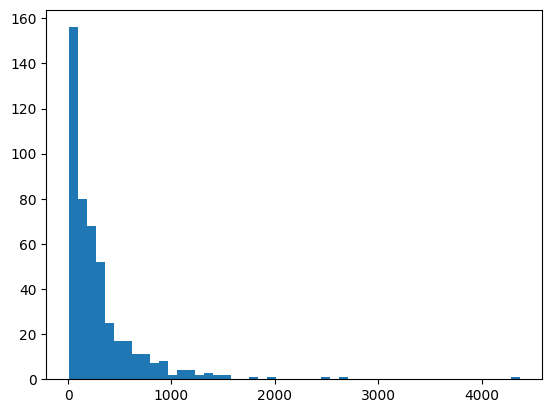

In [ ]:
import matplotlib.pyplot as plt

plt.hist(total_token_counts_list, bins=50)

The histogram is quite peculiar. We see that most thoughts are relatively short, though there are several very long ones.

### LLM underthinking

This part is inspired by [Thoughts Are All Over the Place: On the Underthinking of o1-Like LLMs](https://arxiv.org/pdf/2501.18585). This paper investigated connection between the length of thought branches (fragments of solution between "Alternatively", "Wait", etc) and the solution accuracy. The found out that in many cases LLMs abandon promising solutions, cutting thought branches short before they could come to fruition - and this might contribute to failure of the whole solution.

**Your task**: create on one plot two histograms of branch lengths - one histogram for tasks with correct answer and one of tasks with incorrect answer. You can find information about answer correctness in `qwq_results["evaluation_log"]` (`"is_correct"` fields).

Since there is a different number of correct and incorrect answers in the data, we recommend normalizing the histograms so that they show frequency instead of count. This may be done by setting `density=True`. Do you see any specific patterns?

**Solution** Below we compare histograms of thought length for correct and incorrect solutions. It seems that there are indeed more very short thoughts in incorrect solutions.

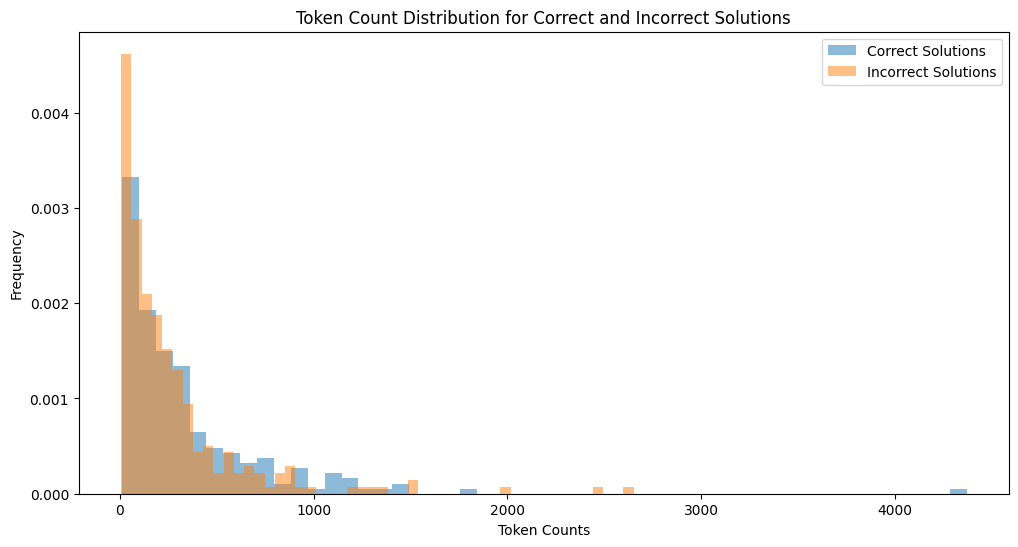

In [ ]:
import matplotlib.pyplot as plt
correct_problems = [problem_id for problem_id, result in enumerate(qwq_results["evaluation_log"]) if result["is_correct"]]
incorrect_problems = [problem_id for problem_id, result in enumerate(qwq_results["evaluation_log"]) if not result["is_correct"]]

correct_token_counts = []
for problem_id in correct_problems:
    if problem_id in total_token_counts:
        correct_token_counts.extend(total_token_counts[problem_id])

incorrect_token_counts = []
for problem_id in incorrect_problems:
    if problem_id in total_token_counts:
        incorrect_token_counts.extend(total_token_counts[problem_id])

plt.figure(figsize=(12, 6))
plt.hist(correct_token_counts, bins=50, alpha=0.5, label='Correct Solutions', density=True)
plt.hist(incorrect_token_counts, bins=50, alpha=0.5, label='Incorrect Solutions', density=True)
plt.xlabel('Token Counts')
plt.ylabel('Frequency')
plt.title('Token Count Distribution for Correct and Incorrect Solutions')
plt.legend(loc='upper right')
plt.show()


Let's also output some of the longest and shortest thoughts.

In [ ]:
long_thoughts = []

for problem_id, token_counts in total_token_counts.items():
    for thought_id, count in enumerate(token_counts):
        if count > 1500:
            long_thoughts.append((problem_id, thought_id, count, len(token_counts)))
            print(f"Tought with {count} tokens; total {len(token_counts)} thoughts")

long_thoughts

Tought with 2651 tokens; total 14 thoughts
Tought with 1522 tokens; total 1 thoughts
Tought with 2467 tokens; total 13 thoughts
Tought with 4369 tokens; total 4 thoughts
Tought with 1983 tokens; total 28 thoughts
Tought with 1819 tokens; total 1 thoughts


[(1, 11, 2651, 14),
 (7, 0, 1522, 1),
 (18, 4, 2467, 13),
 (32, 0, 4369, 4),
 (33, 6, 1983, 28),
 (41, 0, 1819, 1)]

In [ ]:
for problem_id, thought_id, count, thought_len in long_thoughts:
    print(f"""With {count} tokens:
    {thought_decompositions[problem_id][thought_id]}\n\n""")

With 2651 tokens:
    Alternatively, perhaps I can look at the limit as \( x \) approaches 1 or -1,
but that might not be straightforward.

Another idea: since \( p(x) \) is a polynomial of degree 5, and we have its
values at six points, perhaps I can set up a system of equations to solve for
its coefficients. While this is possible, it's quite tedious to do by hand, so
there must be a smarter way.

Let me consider using Lagrange interpolation directly to find \( p(8) \). The
Lagrange interpolation formula for a polynomial passing through points \( (x_1,
y_1), (x_2, y_2), \dots, (x_6, y_6) \) is:

\[
p(x) = \sum_{i=1}^6 y_i \ell_i(x)
\]

where \( \ell_i(x) = \prod_{j \neq i} \frac{x - x_j}{x_i - x_j} \).

In this case, the points are \( x_i = 2, 3, 4, 5, 6, 7 \), and \( y_i =
\frac{x_i}{x_i^2 - 1} \).

So,

\[
p(8) = \sum_{i=2}^7 \left( \frac{i}{i^2 - 1} \right) \ell_i(8)
\]

where

\[
\ell_i(8) = \prod_{j \neq i} \frac{8 - j}{i - j}
\]

This seems manageable, but still a bit cumbersom

In [ ]:
short_thoughts = []

for problem_id, token_counts in total_token_counts.items():
    for thought_id, count in enumerate(token_counts):
        if count < 20:
            short_thoughts.append((problem_id, thought_id, count, len(token_counts)))
            print(f"In problem {problem_id}, tought no. {thought_id} with {count} tokens; total {len(token_counts)} thoughts")

In problem 5, tought no. 6 with 19 tokens; total 50 thoughts
In problem 5, tought no. 15 with 18 tokens; total 50 thoughts
In problem 5, tought no. 19 with 8 tokens; total 50 thoughts
In problem 5, tought no. 21 with 7 tokens; total 50 thoughts
In problem 5, tought no. 24 with 7 tokens; total 50 thoughts
In problem 5, tought no. 32 with 10 tokens; total 50 thoughts
In problem 5, tought no. 39 with 17 tokens; total 50 thoughts
In problem 5, tought no. 43 with 16 tokens; total 50 thoughts
In problem 8, tought no. 2 with 16 tokens; total 18 thoughts
In problem 8, tought no. 11 with 13 tokens; total 18 thoughts
In problem 14, tought no. 2 with 19 tokens; total 4 thoughts
In problem 18, tought no. 6 with 14 tokens; total 13 thoughts
In problem 24, tought no. 8 with 11 tokens; total 11 thoughts
In problem 30, tought no. 5 with 14 tokens; total 14 thoughts
In problem 30, tought no. 10 with 19 tokens; total 14 thoughts
In problem 33, tought no. 7 with 15 tokens; total 28 thoughts
In problem 33

In [ ]:
for problem_id, thought_id, count, thought_len in short_thoughts:
    print(f"""With {count} tokens:
    {thought_decompositions[problem_id][thought_id]}\n\n""")

With 19 tokens:
    Wait, maybe it's better to fix one person and arrange the rest relative to that
person


With 18 tokens:
    Wait, but that's what I did earlier, and I got 288 arrangements


With 8 tokens:
    Wait, no, that's not right


With 7 tokens:
    Wait, now I'm getting confused


With 7 tokens:
    Wait, that doesn't seem right


With 10 tokens:
    Wait, perhaps I need to think about it differently


With 17 tokens:
    Alternatively, perhaps I can use the principle of inclusion-exclusion in a
different way


With 16 tokens:
    Wait, no. If D is seated between two of them, it's possible


With 16 tokens:
    Alternatively, perhaps I should consider the binomial coefficients or the signs
more carefully


With 13 tokens:
    Alternatively, perhaps there's a different approach to find the constant term


With 19 tokens:
    Wait a minute, let me double-check that. Maybe there's a faster way to do this


With 14 tokens:
    Alternatively, use the reduction formula or expres

It looks like the longest thought branches are computation-heavy, while the shortest ones look somewhat abrupt like the LLM really adandoned them without further elaboration.

## Task 2. Convince me with smiles

This is a continuation of the "reasoning dot by dot" section.

**Your task**: still working with **Llama-3.1-8B**, try to prompt it to output other things instead of reasoning. We personally recommend trying dots, commas, pluses, and smiles - they'll produce diverse and interesting patterns. However, feel free to try whatever you like! Don't forget to print several examples of this "reasoning". They might give you some additional insights.

Also, try running the same experiment with **Qwen/Qwen2.5-32B-Instruct**. Will you see a similar effect? Try changing not only models, but also prompts. Check how if affects the metrics.

**Solution**. Let's run experiments with **Llama-3.1-8B** and **Qwen2.5-32B-Instruct**

In [ ]:
dot_prompt = """You are given a question in {topic_prettified} with four answer options labeled by A, B, C, and D.
Instead of reasoning, output <placeholder>. Then, after #ANSWER: only output one of the letters - A, B, C, or D, the correct answer label.

QUESTION: {question}

ANSWER OPTIONS:
A: {A}
B: {B}
C: {C}
D: {D}
"""

dot_options = ["dots", "commas", "dashes", "pluses", "smiles"]

n_questions = 50

results = {}

for dot_option in dot_options:
    print(f"With {dot_option}")
    dot_evaluator = MMLUEvaluator(topic="high_school_mathematics",
                          prompt=dot_prompt.replace("<placeholder>", dot_option))

    dot_results = dot_evaluator.run_evaluation(model="meta-llama/Meta-Llama-3.1-8B-Instruct",
                         n_questions=n_questions)

    results[dot_option] = dot_results

    print(f'\nAccuracy: {dot_results["accuracy"]}')
    print(dot_results['evaluation_log'][0])

With dots


100%|██████████| 50/50 [00:13<00:00,  3.58it/s]



Accuracy: 0.36
{'answer': 'B', 'model_response': '.............................................................\nANSWER: B', 'is_correct': False}
With commas


100%|██████████| 50/50 [04:38<00:00,  5.57s/it]



Accuracy: 0.08
{'answer': ',', 'model_response': '\n,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

100%|██████████| 50/50 [00:13<00:00,  3.75it/s]



Accuracy: 0.34
{'answer': 'B', 'model_response': '------------------------\n\n#ANSWER: B', 'is_correct': False}
With pluses


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]



Accuracy: 0.32
{'answer': 'B', 'model_response': '++++++++++++++++++++++++++\n#ANSWER: B', 'is_correct': False}
With smiles


100%|██████████| 50/50 [00:18<00:00,  2.68it/s]


Accuracy: 0.36
{'answer': 'B', 'model_response': ':-) :-)\n:-) :-)\n:-) :-)\n:-) #ANSWER: B', 'is_correct': False}


For **Llama-3.1-8B**, dots and smiles give stable gain over the no-CoT option (which reaches accuracy 0.26). With commas, quality deteriorates, because, for some reason, it just can't stop generating commas...

In [ ]:
dot_prompt = """You are given a question in {topic_prettified} with four answer options labeled by A, B, C, and D.
Instead of reasoning, output <placeholder>. Then, after #ANSWER: only output one of the letters - A, B, C, or D, the correct answer label.

QUESTION: {question}

ANSWER OPTIONS:
A: {A}
B: {B}
C: {C}
D: {D}
"""

dot_options = ["dots", "commas", "dashes", "pluses", "smiles"]

n_questions = 50

results = {}

for dot_option in dot_options:
    print(f"With {dot_option}")
    dot_evaluator = MMLUEvaluator(topic="high_school_mathematics",
                          prompt=dot_prompt.replace("<placeholder>", dot_option))

    dot_results = dot_evaluator.run_evaluation(
        client=client,
        model="Qwen/Qwen2.5-32B-Instruct",
        n_questions=n_questions)

    results[dot_option] = dot_results

    print(f'\nAccuracy: {dot_results["accuracy"]}')
    print(dot_results['evaluation_log'][0])

With dots


100%|██████████| 50/50 [00:15<00:00,  3.13it/s]



Accuracy: 0.7
{'answer': 'A', 'model_response': '....\n#ANSWER: A', 'is_correct': False}
With commas


100%|██████████| 50/50 [00:15<00:00,  3.16it/s]



Accuracy: 0.68
{'answer': 'A', 'model_response': ',\n#ANSWER: A', 'is_correct': False}
With dashes


100%|██████████| 50/50 [00:15<00:00,  3.22it/s]



Accuracy: 0.68
{'answer': 'A', 'model_response': '-----\n#ANSWER: A', 'is_correct': False}
With pluses


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]



Accuracy: 0.7
{'answer': 'A', 'model_response': '+++++\n#ANSWER: A', 'is_correct': False}
With smiles


100%|██████████| 50/50 [32:58<00:00, 39.57s/it]


Accuracy: 0.3
{'answer': 'A', 'model_response': '😊😊😊😊😊\n\n#ANSWER: A', 'is_correct': False}


For **Qwen-2.5-32B**, the situation is somewhat different. It looks like it just doesn't try to generate many dots or pluses. The accuracy stays around the no-CoT $0.7$. Sadly, smiling emoji are the only ones to spoil the quality :(

It could be a good idea to experiment with the prompts though, to establish variable-length "dot-solutions" for Qwen as well.